# examples for entangling layers

## implement with CNOT gates

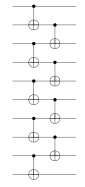

In [1]:
using Yao, YaoPlots

# number of qubits
num_qubit = 10 

# function that creates the entangling layers with Controlled-NOT gates
Ent_CX(nbit::Int64) = (nbit%2 == 0) ? 
    chain(chain(nbit,control(i,i+1=>X) for i in 1:2:nbit-1),
          chain(nbit,control(i,i+1=>X) for i in 2:2:nbit-2)) : 
    chain(chain(nbit,control(i,i+1=>X) for i in 1:2:nbit-2),
          chain(nbit,control(i,i+1=>X) for i in 2:2:nbit-1))
Ent_Layer = Ent_CX(num_qubit)
# display the entangling layer's structure
YaoPlots.plot(Ent_Layer) 

## implement with CZ gates

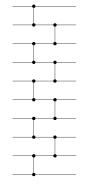

In [2]:
# function that creates the entangling layers with Controlled-Z gates
Ent_CZ(nbit::Int64) = (nbit%2 == 0) ? 
    chain(chain(nbit,control(i,i+1=>Z) for i in 1:2:nbit-1),
          chain(nbit,control(i,i+1=>Z) for i in 2:2:nbit-2)) : 
    chain(chain(nbit,control(i,i+1=>Z) for i in 1:2:nbit-2),
          chain(nbit,control(i,i+1=>Z) for i in 2:2:nbit-1))
Ent_Layer = Ent_CZ(num_qubit)
# display the entangling layer's structure
YaoPlots.plot(Ent_Layer) 

## double the layer

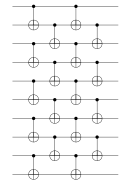

In [3]:
# double the entangling layer of Controlled-NOT gates
Ent_DoubleCX(nbit::Int64) = chain(nbit, Ent_CX(nbit), Ent_CX(nbit))
# display the entangling layer's structure
Ent_Layer = Ent_DoubleCX(num_qubit)
YaoPlots.plot(Ent_Layer) 

## here, we take an example to implement an analog entangling layer, where the Hamiltonian used is from the Aubry-André model (code credit: Wenjie Jiang)

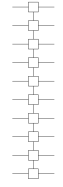

In [4]:
using Distributions
using SparseArrays
using LinearAlgebra
using MAT

function spin_operator(num_spins::Int, sites::Vector{Int}, opts::Vector{Int})
    ops = [sparse([0 1+0im; 1+0im 0]), sparse([0 -1im; 1im 0]), 
        sparse([1+0im 0; 0 -1+0im]), sparse([1+0im 0; 0 1+0im]), 
        sparse([0 1+0im; 0 0]), sparse([0 0; 1+0im 0])]

    idx = [4 for i = 1:num_spins]
    idx[sites] = opts

    opt = sparse([1])
    for i in 1:num_spins
        opt = kron(opt, ops[idx[i]])
    end
    return opt
end

function opts(num_qubits::Int)
    tz = [spin_operator(num_qubits, [k], [3]) for k = 1:num_qubits]
    txx = [spin_operator(num_qubits, [k,k+1], [1,1]) for k = 1:num_qubits-1]
    tyy = [spin_operator(num_qubits, [k,k+1], [2,2]) for k = 1:num_qubits-1]

    return tz, txx, tyy
end

num_qubits = 10
α = (√5 - 1) / 2
φ = 0
# φ = rand(Uniform(0,2π))
hs = [cos(2π*α*k + φ) for k = 1:num_qubits]
#==================num of qubits and random realizations============#

#==================operator============#
m = chain(num_qubits, [put(num_qubits-k+1=>X) for k = 2:2:num_qubits])
tz, txx, tyy = opts(num_qubits);
#==================operator============#

#==================time and disorder============#
dm = 0.
dw = 0.
gm = 1.
gw = 0.

dss = (dm .+ dw * rand(Uniform(0,1), 1)) * hs'
gss = gm .+ gw * rand(Uniform(-1,1), 1, num_qubits-1)
#==================time and disorder============#

# create entangling layers through Hamiltonian evolutions
t = 1.0 # evolution time 

h = sum(dss[1, :] .* tz) .+ sum(gss[1, :] .* (txx + tyy))
# h denotes the matrix formulation of a predefined Hamiltonian
@const_gate Ent_Layer_Analog = exp(-im * t * h |> Array)
# display the entangling layer's structure
YaoPlots.plot(Ent_Layer_Analog)

## with these entangling layers designed, we further define the composite blocks that consist of parameterized single-qubit gates and entangling layers as the building blocks of QNNs from a higher level

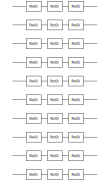

In [5]:
# given the entangling layer Ent_Layer
# we define a parameterized layer consisting of single-qubit rotation gates
RX_layer(nbit::Int64) = chain(put(nbit, i => Rx(0)) for i in 1:nbit)
RZ_layer(nbit::Int64) = chain(put(nbit, i => Rz(0)) for i in 1:nbit)
Params_Layer(nbit::Int64) = chain(RX_layer(nbit),RZ_layer(nbit),RX_layer(nbit))
Parameterized_Layer = Params_Layer(num_qubit)
# display the parameterized layer's structure
YaoPlots.plot(Parameterized_Layer)

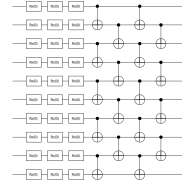

In [6]:
# build a composite block
Composite_Block(nbit::Int64) = chain(nbit, Params_Layer(nbit), Ent_DoubleCX(nbit))
# display the composite block's structure
YaoPlots.plot(Composite_Block(num_qubit))

## set the circuit depth

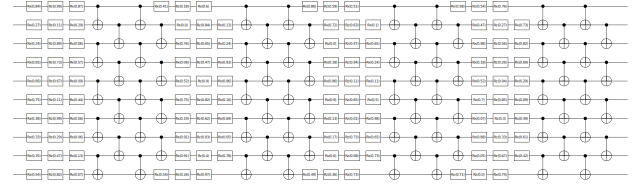

In [7]:
# set the QNN circuit's depth
depth = 4
# repeat the composite block to reach the target depth
circuit = chain(Composite_Block(num_qubit) for _ in 1:depth)
dispatch!(circuit,:random)
# display the QNN circuit's structure
YaoPlots.plot(circuit)